In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [107]:
# Global parameters
N = 100  # no. data points
N_iters = 1000  # max no. iterations before stopping
noise_std = 0.1
beta_tol = 1e-8  # beta tolerance for stopping iteration when |beta_new - beta_old| <= beta_tol
rng_seed = 2023

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 5 - 10*x + 2*x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # ??

beta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)  # own OLS inversion



# Hessian matrices 
H_ols = 2/N * X.T @ X 
eig_ols, _ = np.linalg.eig(H_ols)
print(f"OLS: 1/lambda_max={1/max(eig_ols):.3f}")

OLS: 1/lambda_max=0.385


# Plain gradient descent (GD) convergence as function of fixed learning rate

### OLS:

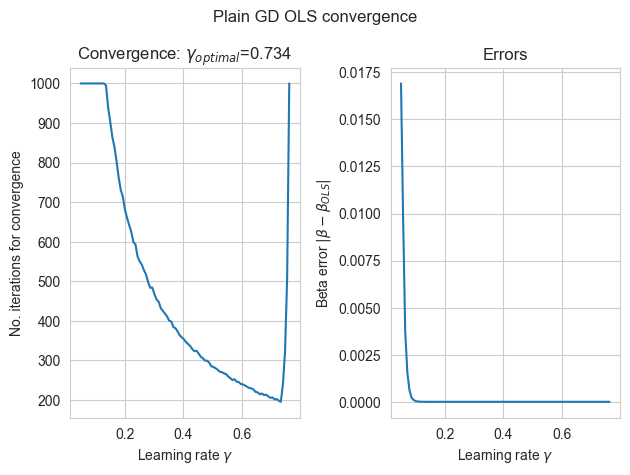

In [108]:
# Parameters
learn_rates = np.linspace(0.05, 2/np.max(eig_ols), 100, endpoint=False)

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = np.random.randn(2, 1)  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()
        
        # Update beta
        grad = 2/N * X.T @ (X @ beta - y)
        beta -= learn_rate * grad
        
        iter += 1
    no_iters[i] = iter
    
    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error


fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Plain GD OLS convergence")

# Plot convergence
axs[0].plot(learn_rates, no_iters)
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors)
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

In [49]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[ 4.65168156 -8.00899928]
Best beta=[ 4.65168155 -8.00899928]
Fastest convergence=195.0


### Ridge:

lmbda=0.001, beta_ridge=[ 4.65095896 -8.00759474], beta=[ 4.58061777 -7.87088291], max error=0.15616862081896699
lmbda=0.01, beta_ridge=[ 4.64446663 -7.99497541], beta=[ 4.03391383 -6.80941246], max error=1.1911934021369017
lmbda=0.1, beta_ridge=[ 4.58061777 -7.87088291], beta=[ 1.9632784  -2.83180382], max error=5.039079708240735
lmbda=1, beta_ridge=[ 4.03391383 -6.80941246], beta=[ 0.47772694 -0.33022129], max error=6.479191098205062
lmbda=10, beta_ridge=[ 1.96327841 -2.83180382], beta=[ 0.07339013 -0.02293347], max error=2.8088816103011425


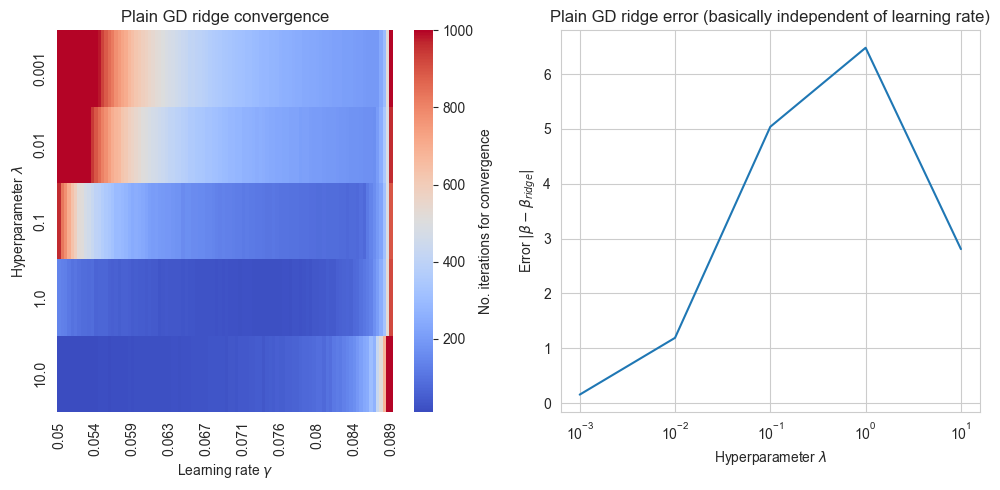

In [50]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I
    
    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2/N*XT_X + 2*lmbda_I  # Hessian matrix
    eig_ridge, _ = np.linalg.eig(H) 
    
    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2/np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = np.random.randn(2, 1)  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()
            
            # Update beta
            grad = 2/N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            beta -= learn_rate * grad
            
            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):  
                iter = 1000
                break
                
            iter += 1
        no_iters[i, j] = iter
        errors[i, j] = max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates)/10)+1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks)/10)+1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
)
plt.xticks(rotation=90)  # sideways xticks
ax.collections[0].colorbar.set_label("No. iterations for convergence")
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Hyperparameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :])  # the errors are the same for each learning rate value
plt.title("Plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Hyperparameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()

In [51]:
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

Min no. iterations=10.0
Fastest convergence combination (gamma, lambda)=(0.050, 10.000) with error=2.809


# Gradient descent with momentum/memory (GDM) as function of fixed learning rate

### OLS:

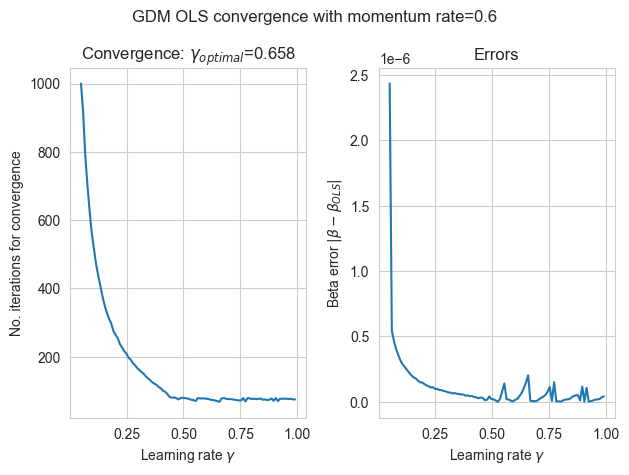

In [91]:
# Parameters
learn_rates = np.linspace(0.05, 1, 100, endpoint=False)
momentum_rate = 0.6  # memory rate

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = np.random.randn(2, 1)  # two random beta parameters
    beta_prev = 0
    change = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()
        
        # Calculate new change
        grad = 2/N * X.T @ (X @ beta - y)
        new_change = learn_rate * grad + momentum_rate * change
        
        # Update values
        beta -= new_change
        change = new_change.copy()
        iter += 1
    no_iters[i] = iter
    
    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error


fig, axs = plt.subplots(1, 2)
fig.suptitle(f"GDM OLS convergence with momentum rate={momentum_rate}")

# Plot convergence
axs[0].plot(learn_rates, no_iters)
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors)
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

In [92]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[ 4.65168156 -8.00899928]
Best beta=[ 4.65168156 -8.00899928]
Fastest convergence=68.0


### Ridge:

lmbda=0.001, beta_ridge=[ 4.65095896 -8.00759474], beta=[ 4.58061777 -7.87088291], max error=0.15616862081896699
lmbda=0.01, beta_ridge=[ 4.64446663 -7.99497541], beta=[ 4.03391383 -6.80941246], max error=1.1911934021369017
lmbda=0.1, beta_ridge=[ 4.58061777 -7.87088291], beta=[ 1.9632784  -2.83180382], max error=5.039079708240735
lmbda=1, beta_ridge=[ 4.03391383 -6.80941246], beta=[ 0.47772694 -0.33022129], max error=6.479191098205062
lmbda=10, beta_ridge=[ 1.96327841 -2.83180382], beta=[ 0.07339013 -0.02293347], max error=2.8088816103011425


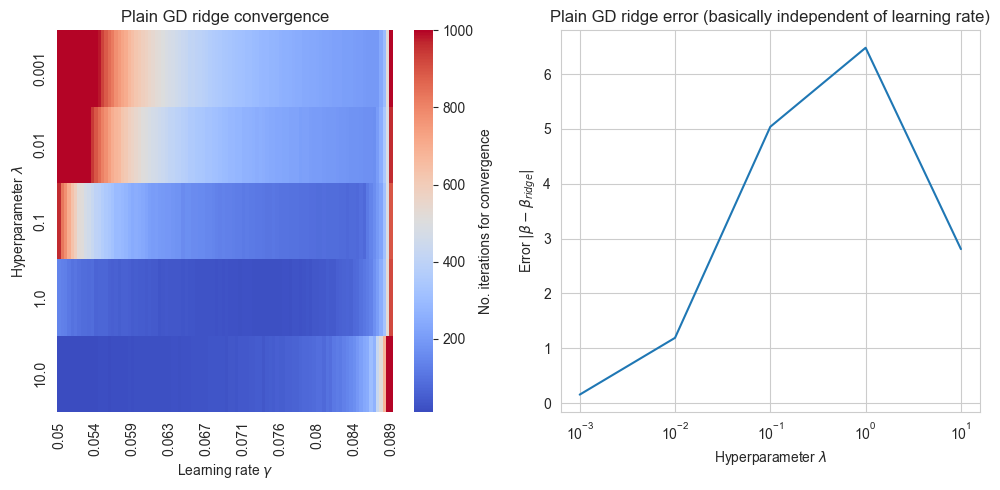

In [50]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I
    
    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2/N*XT_X + 2*lmbda_I  # Hessian matrix
    eig_ridge, _ = np.linalg.eig(H) 
    
    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2/np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = np.random.randn(2, 1)  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        change = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()
            
            # Calculate new change
            grad = 2/N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            new_change = learn_rate * grad + momentum_rate * change
            
            # Update values
            beta -= new_change
            change = new_change.copy()
            iter += 1
            
            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break
                
        no_iters[i, j] = iter
        errors[i, j] = max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates)/10)+1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks)/10)+1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
)
plt.xticks(rotation=90)  # sideways xticks
ax.collections[0].colorbar.set_label("No. iterations for convergence")
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Hyperparameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :])  # the errors are the same for each learning rate value
plt.title("Plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Hyperparameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()

In [ ]:
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

In [54]:
# Iterate through and improve beta
beta_pp = np.random.randn(2, 1)
beta_prev = 2 / N * X.T @ (X @ beta_pp - y)
beta = 2/N * X.T @ (X @ beta_prev - y)
i = 0
while i < N_iters - 2 and any(abs(beta - beta_prev) > beta_tol):  # convergence test
    beta_pp = beta_prev.copy()
    beta_prev = beta.copy()
    grad = 2/N * X.T @ (X @ beta - y) + 2*lmbda*beta
    beta += momentum_rate * (beta_prev - beta_pp) - learn_rate * grad
    i += 1
iters_mgd_ols = i
beta_mgd_ols = beta

C:\Users\Lasse\AppData\Local\Temp\ipykernel_19288\3992420203.py:9: RuntimeWarning: overflow encountered in multiply
  grad = 2/N * X.T @ (X @ beta - y) + 2*lmbda*beta
C:\Users\Lasse\AppData\Local\Temp\ipykernel_19288\3992420203.py:10: RuntimeWarning: invalid value encountered in subtract
  beta += momentum_rate * (beta_prev - beta_pp) - learn_rate * grad


# Stochastic gradient descent (SDG)

In [55]:
# SDG parameters
learn_rate = 0.4
M = N/100  # size of each minibatch
m = int(N/M)  # number of minibatches
N_epochs = 50  # number of iterations over all minibatches 



# Print results

In [56]:
print(f"Own inversion:\n"
      f"1/max(OLS eigenvalues)={1/max(eig_ols):g}\n"
      f"1/max(Ridge eigenvalues)={1/max(eig_ridge):g}\n"
      f"OLS beta={beta_ols.ravel()}\n"
      f"Ridge beta={beta_ridge.ravel()}\n"
      f"Beta tolerance={beta_tol}\n"
      f"Max iterations={N_iters}\n")
print(f"Own GD code:\n"
      f"Learning rate={learn_rate}\n"
      f"OLS beta={beta_gd_ols.ravel()}\n"
      f"OLS iterations={iters_gd_ols}\n"
      f"Ridge beta={beta_gd_ridge.ravel()}\n"
      f"Ridge iterations={iters_gd_ridge}\n")
print(f"Own GD w/momentum code:\n"
      f"Learning rate={learn_rate}\n"
      f"momentum rate={momentum_rate}\n"
      f"OLS beta={beta_mgd_ols.ravel()}\n"
      f"OLS iterations={iters_mgd_ols}\n"
      f"Ridge beta={beta_mgd_ridge.ravel()}\n"
      f"Ridge iterations={iters_mgd_ridge}\n")

Own inversion:
1/max(OLS eigenvalues)=0.401248
1/max(Ridge eigenvalues)=0.0444598
OLS beta=[ 4.65168156 -8.00899928]
Ridge beta=[ 1.96327841 -2.83180382]
Beta tolerance=1e-08
Max iterations=1000


NameError: name 'beta_gd_ols' is not defined